<a href="https://colab.research.google.com/github/MIBRivera/MASS-internship/blob/main/Dynesty_x_GPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install gpy dynesty

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420841 sha256=2f34af93ac9c3f9a5f4b7c1050eef6a44b13bf1923cbe759248ff1ffad2a597e
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102543 sha256=f21aca6b5926579e016d98b14a7bc8a4a4281737e502f5ac378fa067d87fc886
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built gpy paramz


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import dynesty as dy
import scipy

%matplotlib inline

# seed the random number generator
rstate = np.random.default_rng(626)

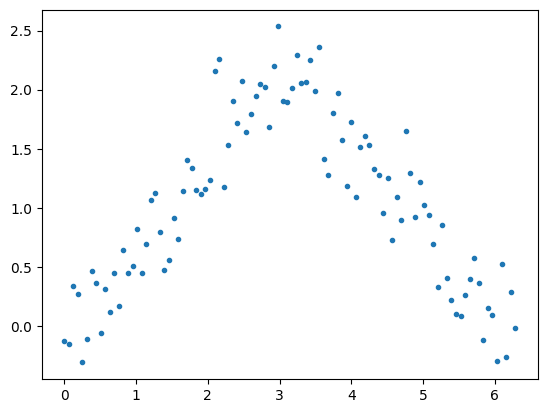

In [4]:
# Let's make some synthetic data
x = np.linspace(0.,2*np.pi,100)[:,None]
y = -np.cos(x)+np.random.randn(*x.shape)*0.3+1
_ = plt.plot(x,y,'.')

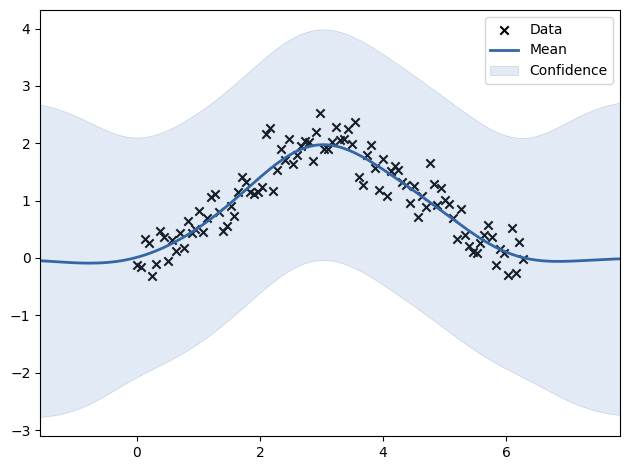

In [5]:
# Make a GP regression model
m = GPy.models.GPRegression(x,y)
# Give some general prior distributions for model parameters
m.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.kern.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
m.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1.,10.))
_=m.plot()

In [6]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,"Ga(0.1, 0.1)"
rbf.lengthscale,1.0,+ve,"Ga(0.1, 0.1)"
Gaussian_noise.variance,1.0,+ve,"Ga(0.1, 0.1)"


In [12]:
# Set the number of dimensions (parameters) and their bounds
ndim = 3
bounds = [(1e-3, 1e1),(1e-3, 1e1), (1e-3, 1e1)]  # example bounds for RBF variance, RBF lengthscale, and Gaussian noise variance, respectively
epsilon = 1e-10

def negative_log_likelihood(params):
    # Assuming params is a vector of hyperparameters
    kernel = GPy.kern.RBF(input_dim=1, variance=params[0], lengthscale=params[1])
    model = GPy.models.GPRegression(x, y, kernel, noise_var=1.0)

    # Return negative log marginal likelihood
    return -model.log_likelihood()

def prior_transform(u):
    # Map from [0, 1) to Gamma.from_EV(1,10)
    scaled_u = [u_i * (1.0 - epsilon) for u_i in u]
    hyperparameters = [scipy.stats.gamma.ppf(u_i,a=1.0,scale=10.0) for u_i in scaled_u]
    return hyperparameters

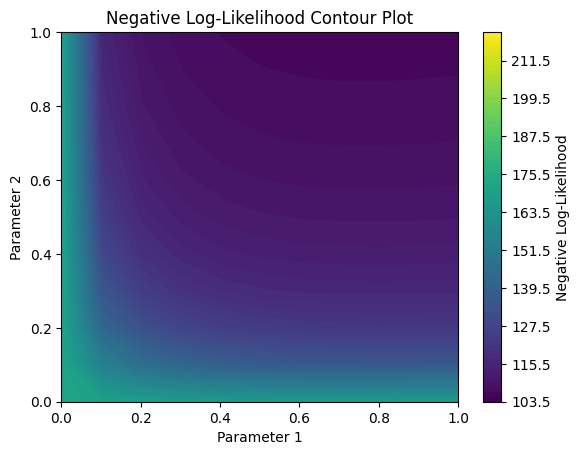

In [14]:
# Define the bounds of the prior space for each hyperparameter
prior_bounds = [(1e-3, 1e1), (1e-3, 1e1)]

# Create a grid of parameter values
param1_values = np.linspace(prior_bounds[0][0], prior_bounds[0][1], 100)
param2_values = np.linspace(prior_bounds[1][0], prior_bounds[1][1], 100)
param1_mesh, param2_mesh = np.meshgrid(param1_values, param2_values)
params_mesh = np.vstack([param1_mesh.ravel(), param2_mesh.ravel()]).T

# Compute the negative log-likelihood for each point in the parameter space
negative_log_likelihood_values = np.array([negative_log_likelihood(params) for params in params_mesh])

# Reshape the values for contour plotting
negative_log_likelihood_values = negative_log_likelihood_values.reshape(param1_mesh.shape)

# Plot the contour plot
plt.contourf(param1_mesh, param2_mesh, negative_log_likelihood_values, cmap='viridis', levels=100)
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Negative Log-Likelihood Contour Plot')
plt.show()

In [ ]:
# Create a nested sampler
# sampler = dy.NestedSampler(negative_log_likelihood, prior_transform, ndim=ndim, nlive=1500, sample='auto')

In [ ]:
# sampler.run_nested()
# results = sampler.results

In [ ]:
sampler_dyn = dy.DynamicNestedSampler(negative_log_likelihood, prior_transform, ndim=ndim, bound='single', sample='unif', update_interval=50., rstate=rstate)
sampler_dyn.run_nested(maxiter=20000, use_stop=False)
results_dyn = sampler_dyn.results

7551it [1:00:00, 10.16it/s, batch: 0 | bound: 11 | nc: 8 | ncall: 269987 | eff(%):  2.792 | loglstar:   -inf < 1941684.434 <    inf | logz: 1941662.439 +/-  0.210 | dlogz:    inf >  0.010]

In [1]:
best_fit_params = results_dyn.samples[np.argmin(results_dyn.logl)]
print(best_fit_params)

NameError: ignored

In [ ]:
# Set the model parameters as the posterior mean
m.kern.variance = best_fit_params[0]
m.kern.lengthscale = best_fit_params[1]
m.likelihood.variance = best_fit_params[2]
print(m)
_=m.plot()